# Plot PPI data for BAMS Paper
Plot maps for the SAIL Bulletin of the American Meteorological Society (BAMS) submission.

## Imports

In [5]:
import glob
import os
import datetime
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pyart
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.dates import DateFormatter
import pandas as pd
import geopandas as gpd
from metpy.plots import USCOUNTIES
from matplotlib.colors import ListedColormap
from datetime import datetime
import act
import fiona
from podpac.datalib.terraintiles import TerrainTiles
from podpac import Coordinates, clinspace
import hvplot as hv
import hvplot.xarray
import numpy as np
from math import atan2 as atan2
from matplotlib import colors
from matplotlib import ticker, cm
fiona.drvsupport.supported_drivers['lib?kml'] = 'rw' # enable KML support which is disabled by default
fiona.drvsupport.supported_drivers['LIBKML'] = 'rw' # enable KML support which is disabled by default
warnings.filterwarnings('ignore')

### Read the Watershed and Instrumentation Locations

In [6]:
east_river = gpd.read_file('data/site-locations/East_River.kml')
splash_locations = gpd.read_file('data/site-locations/SPLASH_Instruments.kml')
amf_sensor_locations = gpd.read_file('data/site-locations/SAIL_Instruments.kml')

### Retrieve the DEM Data

In [7]:
min_lat = 38.8
max_lat = 39.1
min_lon = -107.2
max_lon = -106.7

# create terrain tiles node
node = TerrainTiles(tile_format='geotiff', zoom=10)

# create coordinates to get tiles
c = Coordinates([clinspace(min_lat, max_lat, 1000), clinspace(min_lon, max_lon, 1000)], dims=['lat', 'lon'])

# evaluate node
terrain = node.eval(c)

## Setup Helper Functions
We need these helper functions to create the scale bar within our figure

In [8]:
def gc_latlon_bear_dist(lat1, lon1, bear, dist):
    """
    Input lat1/lon1 as decimal degrees, as well as bearing and distance from
    the coordinate. Returns lat2/lon2 of final destination. Cannot be
    vectorized due to atan2.
    """
    re = 6371.1  # km
    lat1r = np.deg2rad(lat1)
    lon1r = np.deg2rad(lon1)
    bearr = np.deg2rad(bear)
    lat2r = np.arcsin((np.sin(lat1r) * np.cos(dist/re)) +
                      (np.cos(lat1r) * np.sin(dist/re) * np.cos(bearr)))
    lon2r = lon1r + atan2(np.sin(bearr) * np.sin(dist/re) *
                          np.cos(lat1r), np.cos(dist/re) - np.sin(lat1r) *
                          np.sin(lat2r))
    return np.rad2deg(lat2r), np.rad2deg(lon2r)
 
    
def add_scale_line(scale, ax, projection, color='k',
                  linewidth=None, fontsize=None, fontweight=None):
    """
    Adds a line that shows the map scale in km. The line will automatically
    scale based on zoom level of the map. Works with cartopy.
 
    Parameters
    ----------
    scale : scalar
        Length of line to draw, in km.
    ax : matplotlib.pyplot.Axes instance
        Axes instance to draw line on. It is assumed that this was created
        with a map projection.
    projection : cartopy.crs projection
        Cartopy projection being used in the plot.
 
    Other Parameters
    ----------------
    color : str
        Color of line and text to draw. Default is black.
    """
    frac_lat = 0.1  # distance fraction from bottom of plot
    frac_lon = 0.5  # distance fraction from left of plot
    e1 = ax.get_extent()
    center_lon = e1[0] + frac_lon * (e1[1] - e1[0])
    center_lat = e1[2] + frac_lat * (e1[3] - e1[2])
    # Main line
    lat1, lon1 = gc_latlon_bear_dist(
        center_lat, center_lon, -90, scale / 2.0)  # left point
    lat2, lon2 = gc_latlon_bear_dist(
        center_lat, center_lon, 90, scale / 2.0)  # right point
    if lon1 <= e1[0] or lon2 >= e1[1]:
        warnings.warn('Scale line longer than extent of plot! ' +
                      'Try shortening for best effect.')
    ax.plot([lon1, lon2], [lat1, lat2], linestyle='-',
            color=color, transform=projection, 
            linewidth=linewidth)
    # Draw a vertical hash on the left edge
    lat1a, lon1a = gc_latlon_bear_dist(
        lat1, lon1, 180, frac_lon * scale / 20.0)  # bottom left hash
    lat1b, lon1b = gc_latlon_bear_dist(
        lat1, lon1, 0, frac_lon * scale / 20.0)  # top left hash
    ax.plot([lon1a, lon1b], [lat1a, lat1b], linestyle='-',
            color=color, transform=projection, linewidth=linewidth)
    # Draw a vertical hash on the right edge
    lat2a, lon2a = gc_latlon_bear_dist(
        lat2, lon2, 180, frac_lon * scale / 20.0)  # bottom right hash
    lat2b, lon2b = gc_latlon_bear_dist(
        lat2, lon2, 0, frac_lon * scale / 20.0)  # top right hash
    ax.plot([lon2a, lon2b], [lat2a, lat2b], linestyle='-',
            color=color, transform=projection, linewidth=linewidth)
    # Draw scale label
    ax.text(center_lon, center_lat - frac_lat * (e1[3] - e1[2]) / 4.0,
            str(int(scale)) + ' km', horizontalalignment='center',
            verticalalignment='center', color=color, fontweight=fontweight,
            fontsize=fontsize)

## Plot the Reflectivity with the Pluvio Sensor and Watershed Locations

In [9]:
def plot_reflectivity_sail(file, out_directory='.'):
    """
    Reads and plots data from the SAIL field campaign
    """
    
    radar = pyart.io.read(file)

    elevation_contours = np.arange(2_700, 4_200, 250)

    fig = plt.figure(figsize=(12,8))

    ax = plt.subplot(111,
                     projection=ccrs.PlateCarree())

    #Setup a RadarMapDisplay, which gives our axes in lat/lon
    display = pyart.graph.RadarMapDisplay(radar)

    # Add our reflectivity (DBZ) field to the plot, including our gatefilter
    radar_plot = display.plot_ppi_map('DBZ',
                                      3,
                                      ax=ax,
                                      vmin=-20,
                                      min_lat=min_lat,
                                      max_lat=max_lat,
                                      min_lon=min_lon,
                                      max_lon=max_lon,
                                      embelish=False,
                                      colorbar_label="Horizontal Reflectivity Factor ($Z_{H}$) \n (dBZ)",
                                      vmax=40.,)

    cbar = display.cbs[0]
    cbar.set_ticklabels(np.arange(-20, 50, 10), fontsize=14)
    cbar.set_label(label='Horizontal Reflectivity Factor ($Z_{H}$) (dBZ)', fontsize=16)

    display.cbs = [cbar]


    east_river.plot(ax=ax,
                    linewidth=3,
                    edgecolor='k',
                    facecolor="None",
                    linestyle='--',)

    ax.plot(0,
            0,
            color='k',
            linestyle=':',
            linewidth=3,
            label='East River Basin')

    amf_sensor_locations.loc[amf_sensor_locations.Name == 'PLUVIO'].plot(ax=ax,
                                                                         color='k',
                                                                         label='ARM AMF Site')

    plt.legend(loc='upper right',
               fontsize=14)

    plt.xlim(min_lon, max_lon)
    plt.ylim(min_lat, max_lat)

    # Add our scale bar
    add_scale_line(10.0, ax, projection=ccrs.PlateCarree(), 
                   color='black', linewidth=3,
                   fontsize=20,
                   fontweight='bold')

    # Add gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(),
                       draw_labels=True,
                       linewidth=1, 
                       color='gray', 
                       alpha=0.3,
                       linestyle='--')

    plt.gca().xaxis.set_major_locator(plt.NullLocator())

    # Make sure labels are only plotted on the left and bottom
    gl.xlabels_top = False
    gl.ylabels_right = False

    gl.xlabel_style = {'size': 14}
    gl.ylabel_style = {'size': 14}

    third_sweep = radar.extract_sweeps([2])
    time = pd.to_datetime(third_sweep.time["data"], unit='s').mean()
    time_in_label = time.strftime("%H%M UTC %d %b %Y")
    time_in_file = time.strftime("%B_%d_%H%M").lower()

    contours = terrain.to_dataset(name='DEM').DEM.plot.contour(levels=elevation_contours, cmap='Greys', alpha=0.6)
    ax.clabel(contours, elevation_contours[::2], fontsize=10, inline=1, fmt='%i m', rightside_up=True)
    #cbar_elevation.set_ticklabels(np.arange(2_000, 5_000, 750), fontsize=14)
    #cbar_elevation.set_label(label='Elevation (meters)', fontsize=16)

    plt.title(f"Horizontal Reflectivity at 6° Elevation \n {time_in_label}", fontsize=20)

    plt.savefig(f"{out_directory}/ppi_4deg_{time_in_file}.png", dpi=300, bbox_inches="tight")

    plt.show()

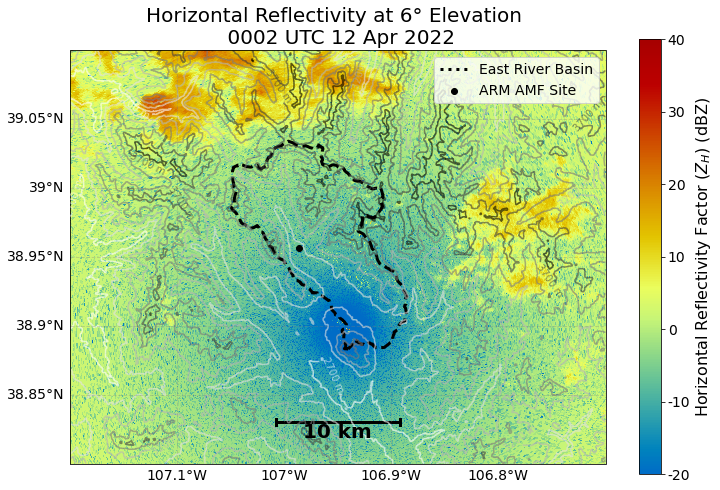

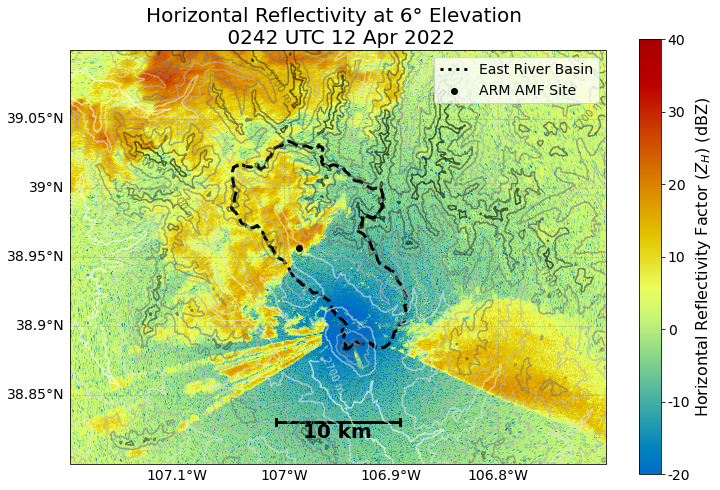

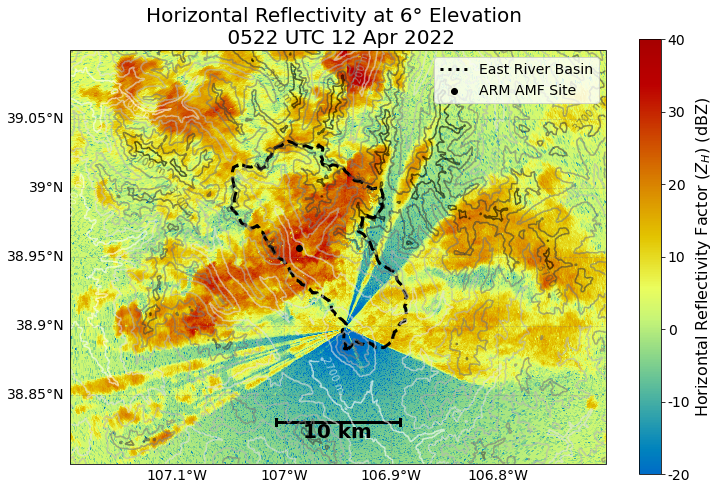

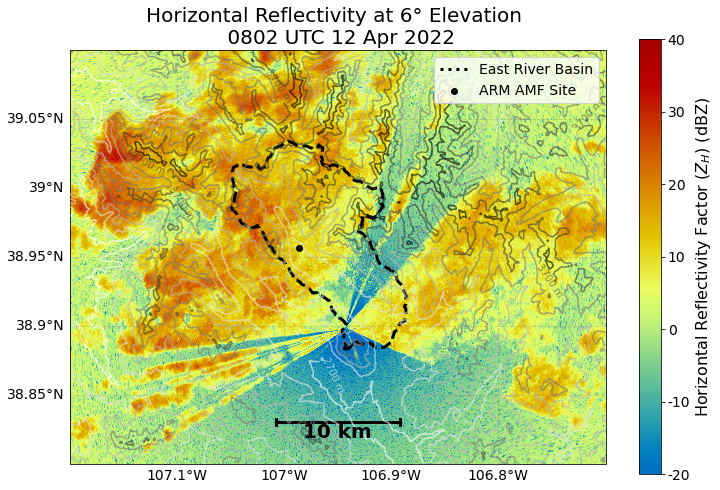

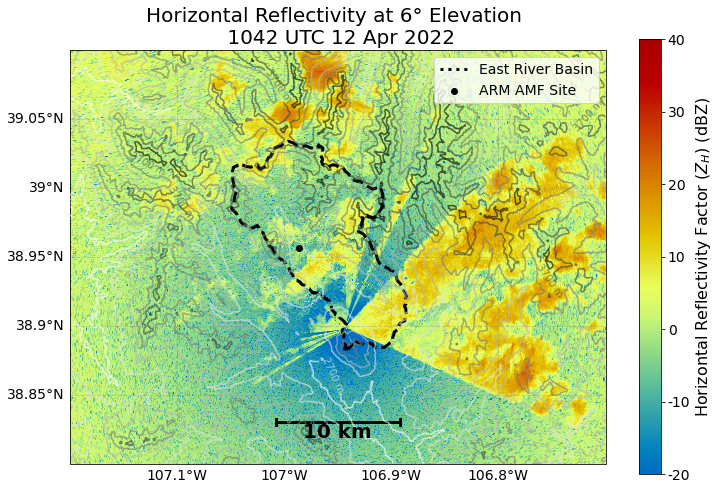

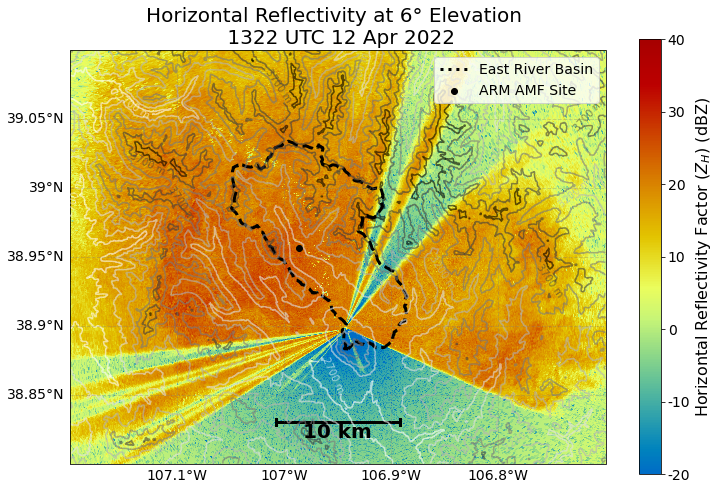

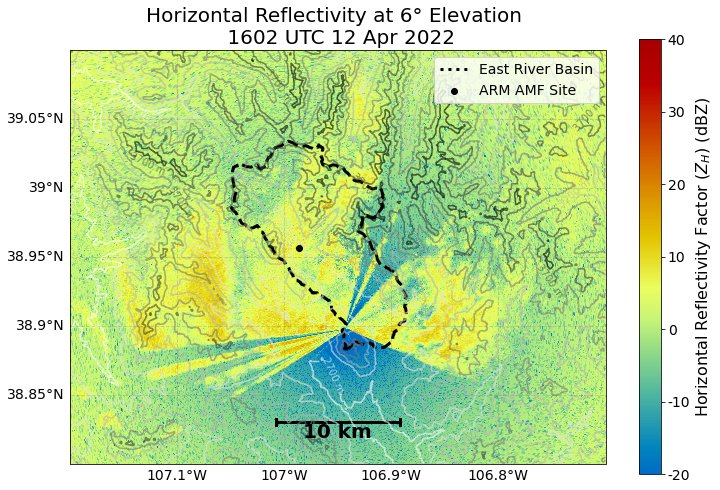

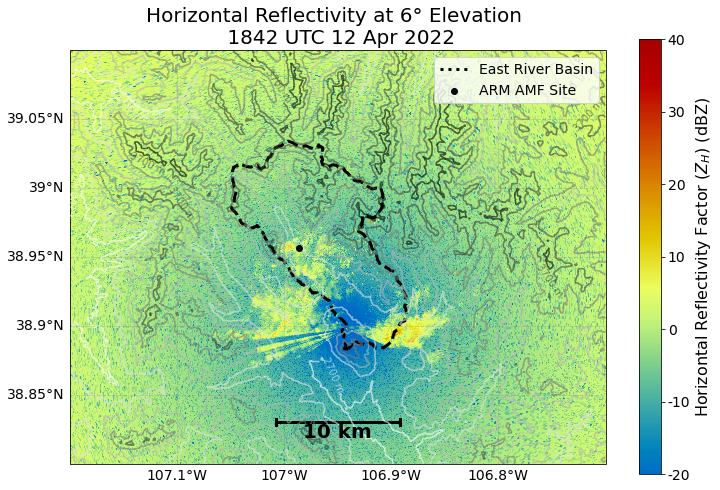

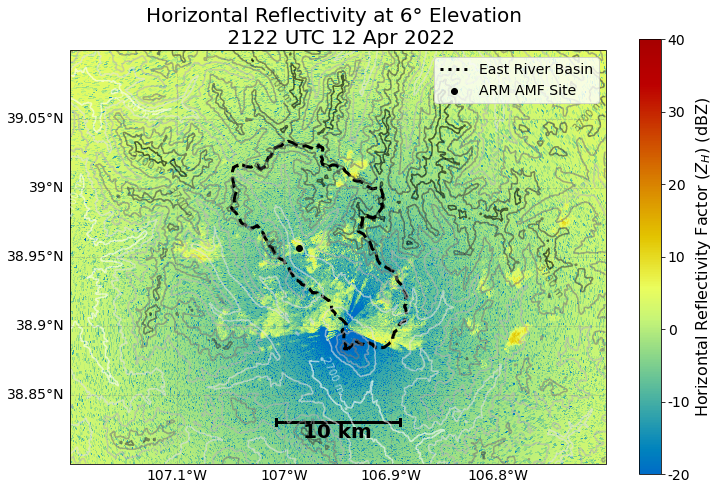

In [10]:
hour = '12'
file_list = sorted(glob.glob(f"/gpfs/wolf/atm124/proj-shared/gucxprecipradarS2.00/glue_files/202204_glued/xprecipradar_guc_volume_20220412-*"))

for file in file_list[::30]:
    plot_reflectivity_sail(file, out_directory='ppi_animation_april14')



---

In [1]:
import glob
ppi_images = sorted(glob.glob("ppi_animation_april14/*"))

In [2]:
import imageio.v2 as imageio
with imageio.get_writer('april-ref-ppi-animation-6deg.gif', mode='I') as writer:
    for filename in ppi_images:
        image = imageio.imread(filename)
        writer.append_data(image)